## Imports

In [43]:
# PART 1
! pip install pandas numpy matplotlib seaborn scikit-learn imbalanced-learn mlflow

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
import mlflow
import mlflow.sklearn


## Data Cleaning

In [44]:
data = pd.read_csv('dataset_all.csv')


def handle_missing_values(data: pd.DataFrame) -> pd.DataFrame:
    """Handle missing values for all the selected features and the target column."""
    selected_columns = ['H', 'diameter', 'q', 'i', 'moid', 'pha']
    data = data[selected_columns]
    for column in selected_columns:
        if data[column].dtype == 'float64':
            data[column].fillna(data[column].mean(), inplace=True)
        elif data[column].dtype == 'object':
            data[column].fillna(data[column].mode()[0], inplace=True)

    # Check for any remaining missing values
    if data.isnull().values.any():
        print("Warning: There are still missing values in the dataset.")
        print(data.isnull().sum())

    return data


data = handle_missing_values(data)

/var/folders/7l/wr39ns_13xdbtxc49y6l0qjh0000gn/T/ipykernel_30883/1471852669.py:1: DtypeWarning: Columns (3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('dataset_all.csv')
/var/folders/7l/wr39ns_13xdbtxc49y6l0qjh0000gn/T/ipykernel_30883/1471852669.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column].fillna(data[column].mean(), inplace=True)
/var/folders/7l/wr39ns_13xdbtxc49y6l0qjh0000gn/T/ipykernel_30883/1471852669.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column].fillna(data[column].mode()[0], inplace=True)


## Select features and split the dataset

In [45]:
# Select features and target
def select_features_and_target(data: pd.DataFrame) -> tuple:
    """Selects the features and target for the machine learning model."""
    features = data[['H', 'diameter', 'q', 'i', 'moid']]
    target = data['pha'].apply(lambda x: 1 if x == 'Y' else 0)
    return features, target


features, target = select_features_and_target(data)
print(target.value_counts())


# Oversample the data
def oversample_data(X: pd.DataFrame, y: pd.Series):
    oversampler = SMOTE(sampling_strategy='minority', random_state=42)
    X_resampled, y_resampled = oversampler.fit_resample(X, y)
    return X_resampled, y_resampled


# Apply oversampling to the whole dataset
X_oversampled, y_oversampled = oversample_data(features, target)

# Split the oversampled data
X_train, X_temp, y_train, y_temp = train_test_split(X_oversampled, y_oversampled, test_size=0.3, random_state=42,
                                                    stratify=y_oversampled)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print(y_train.value_counts())


0    956458
1      2066
Name: pha, dtype: int64
1    669521
0    669520
Name: pha, dtype: int64


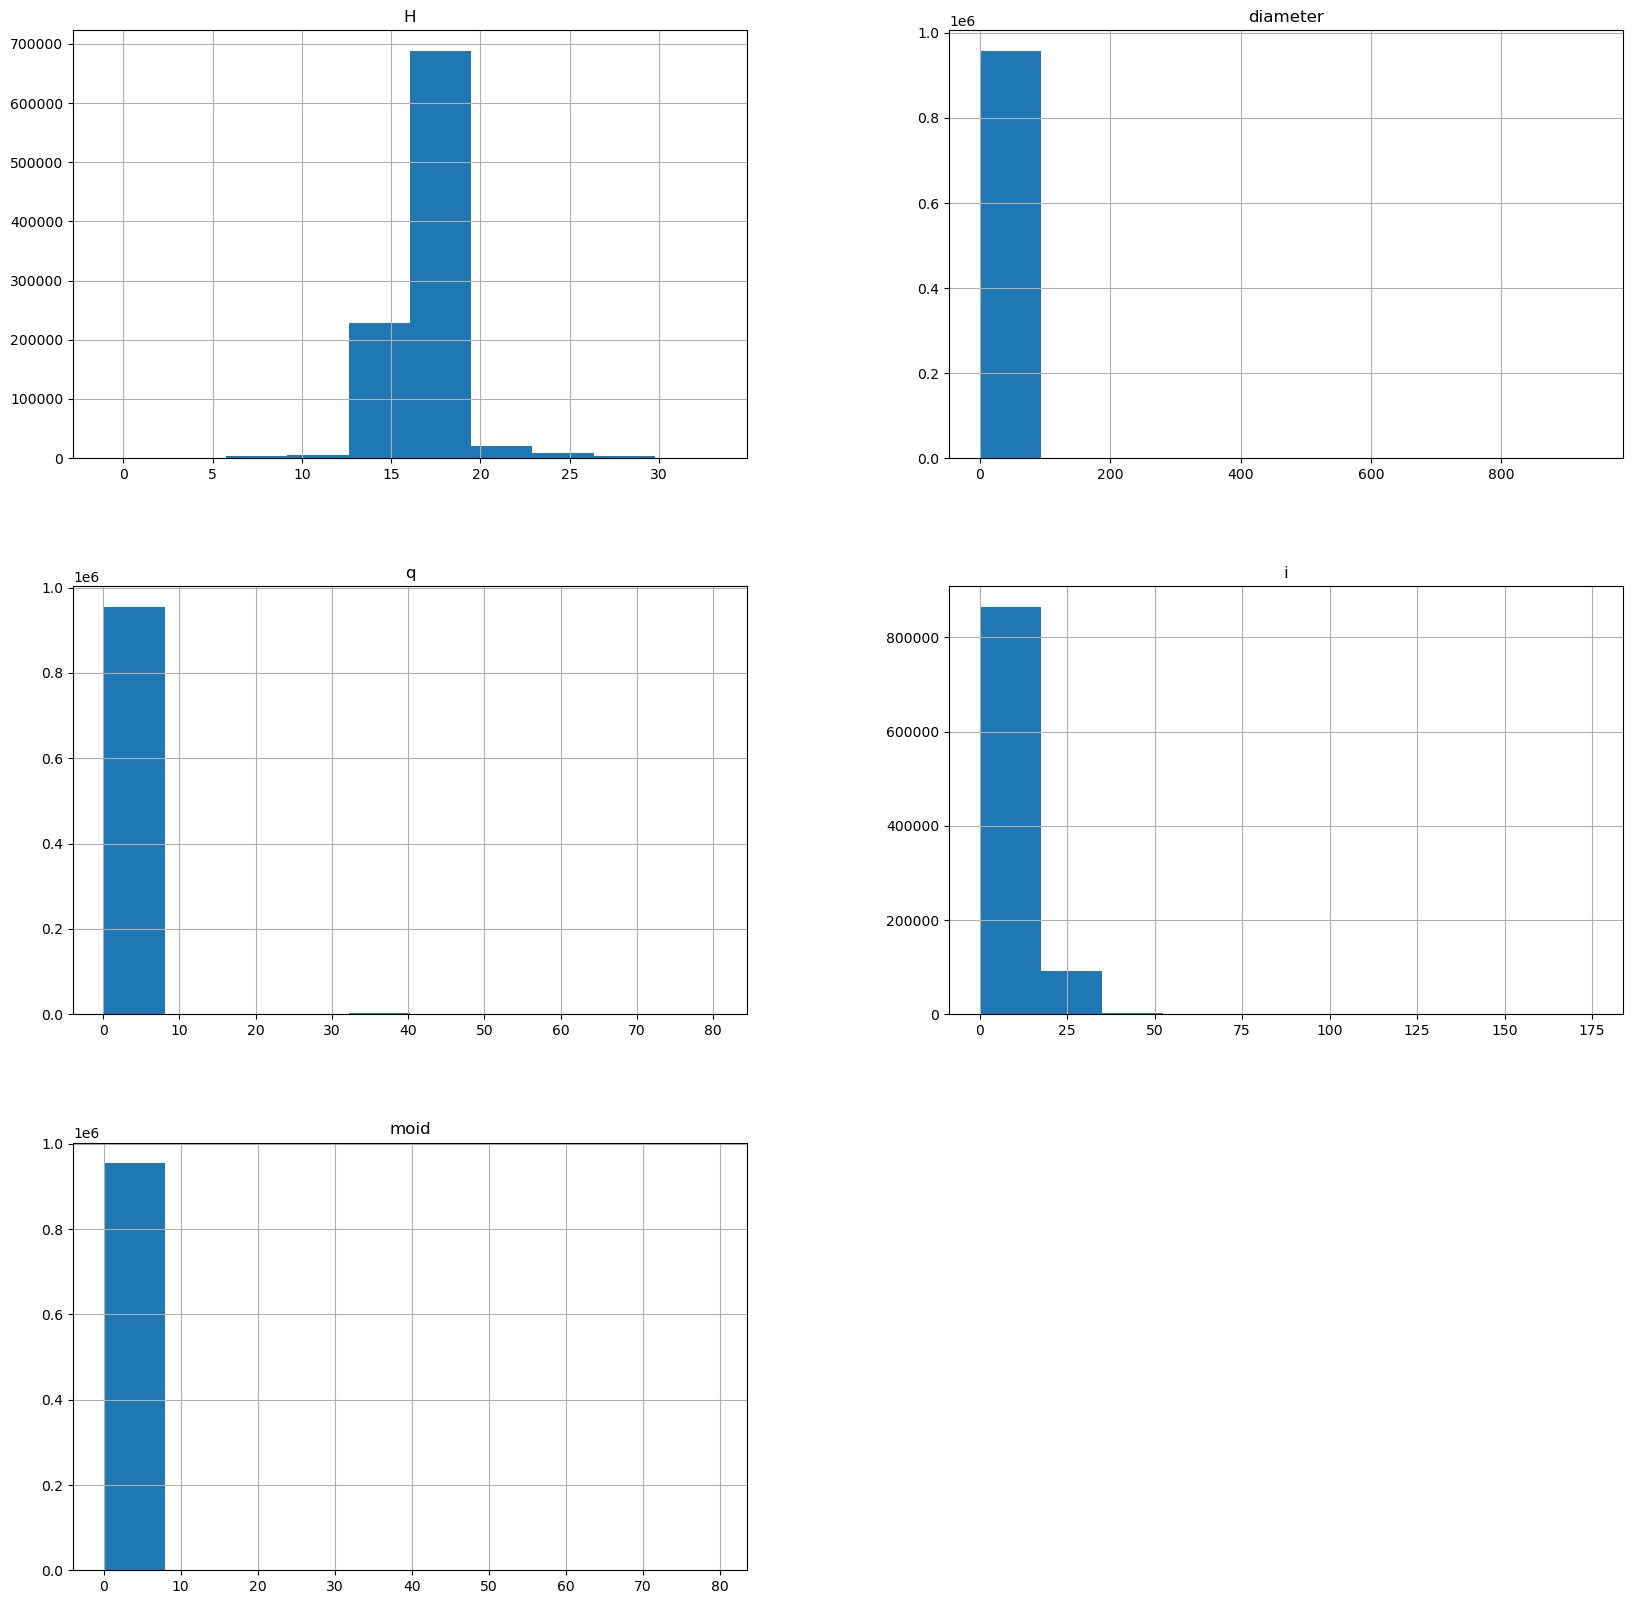

In [46]:
# Visualize the data
def visualize_data(data: pd.DataFrame):
    """Visualizes the input data using histograms and pairplots."""
    # Histograms
    data.hist(figsize=(20, 20))
    plt.show()

    # Pairplot (select a subset of columns for better readability)
    subset = data[['pha']]
    sns.pairplot


visualize_data(data)

/var/folders/7l/wr39ns_13xdbtxc49y6l0qjh0000gn/T/ipykernel_30883/91285669.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


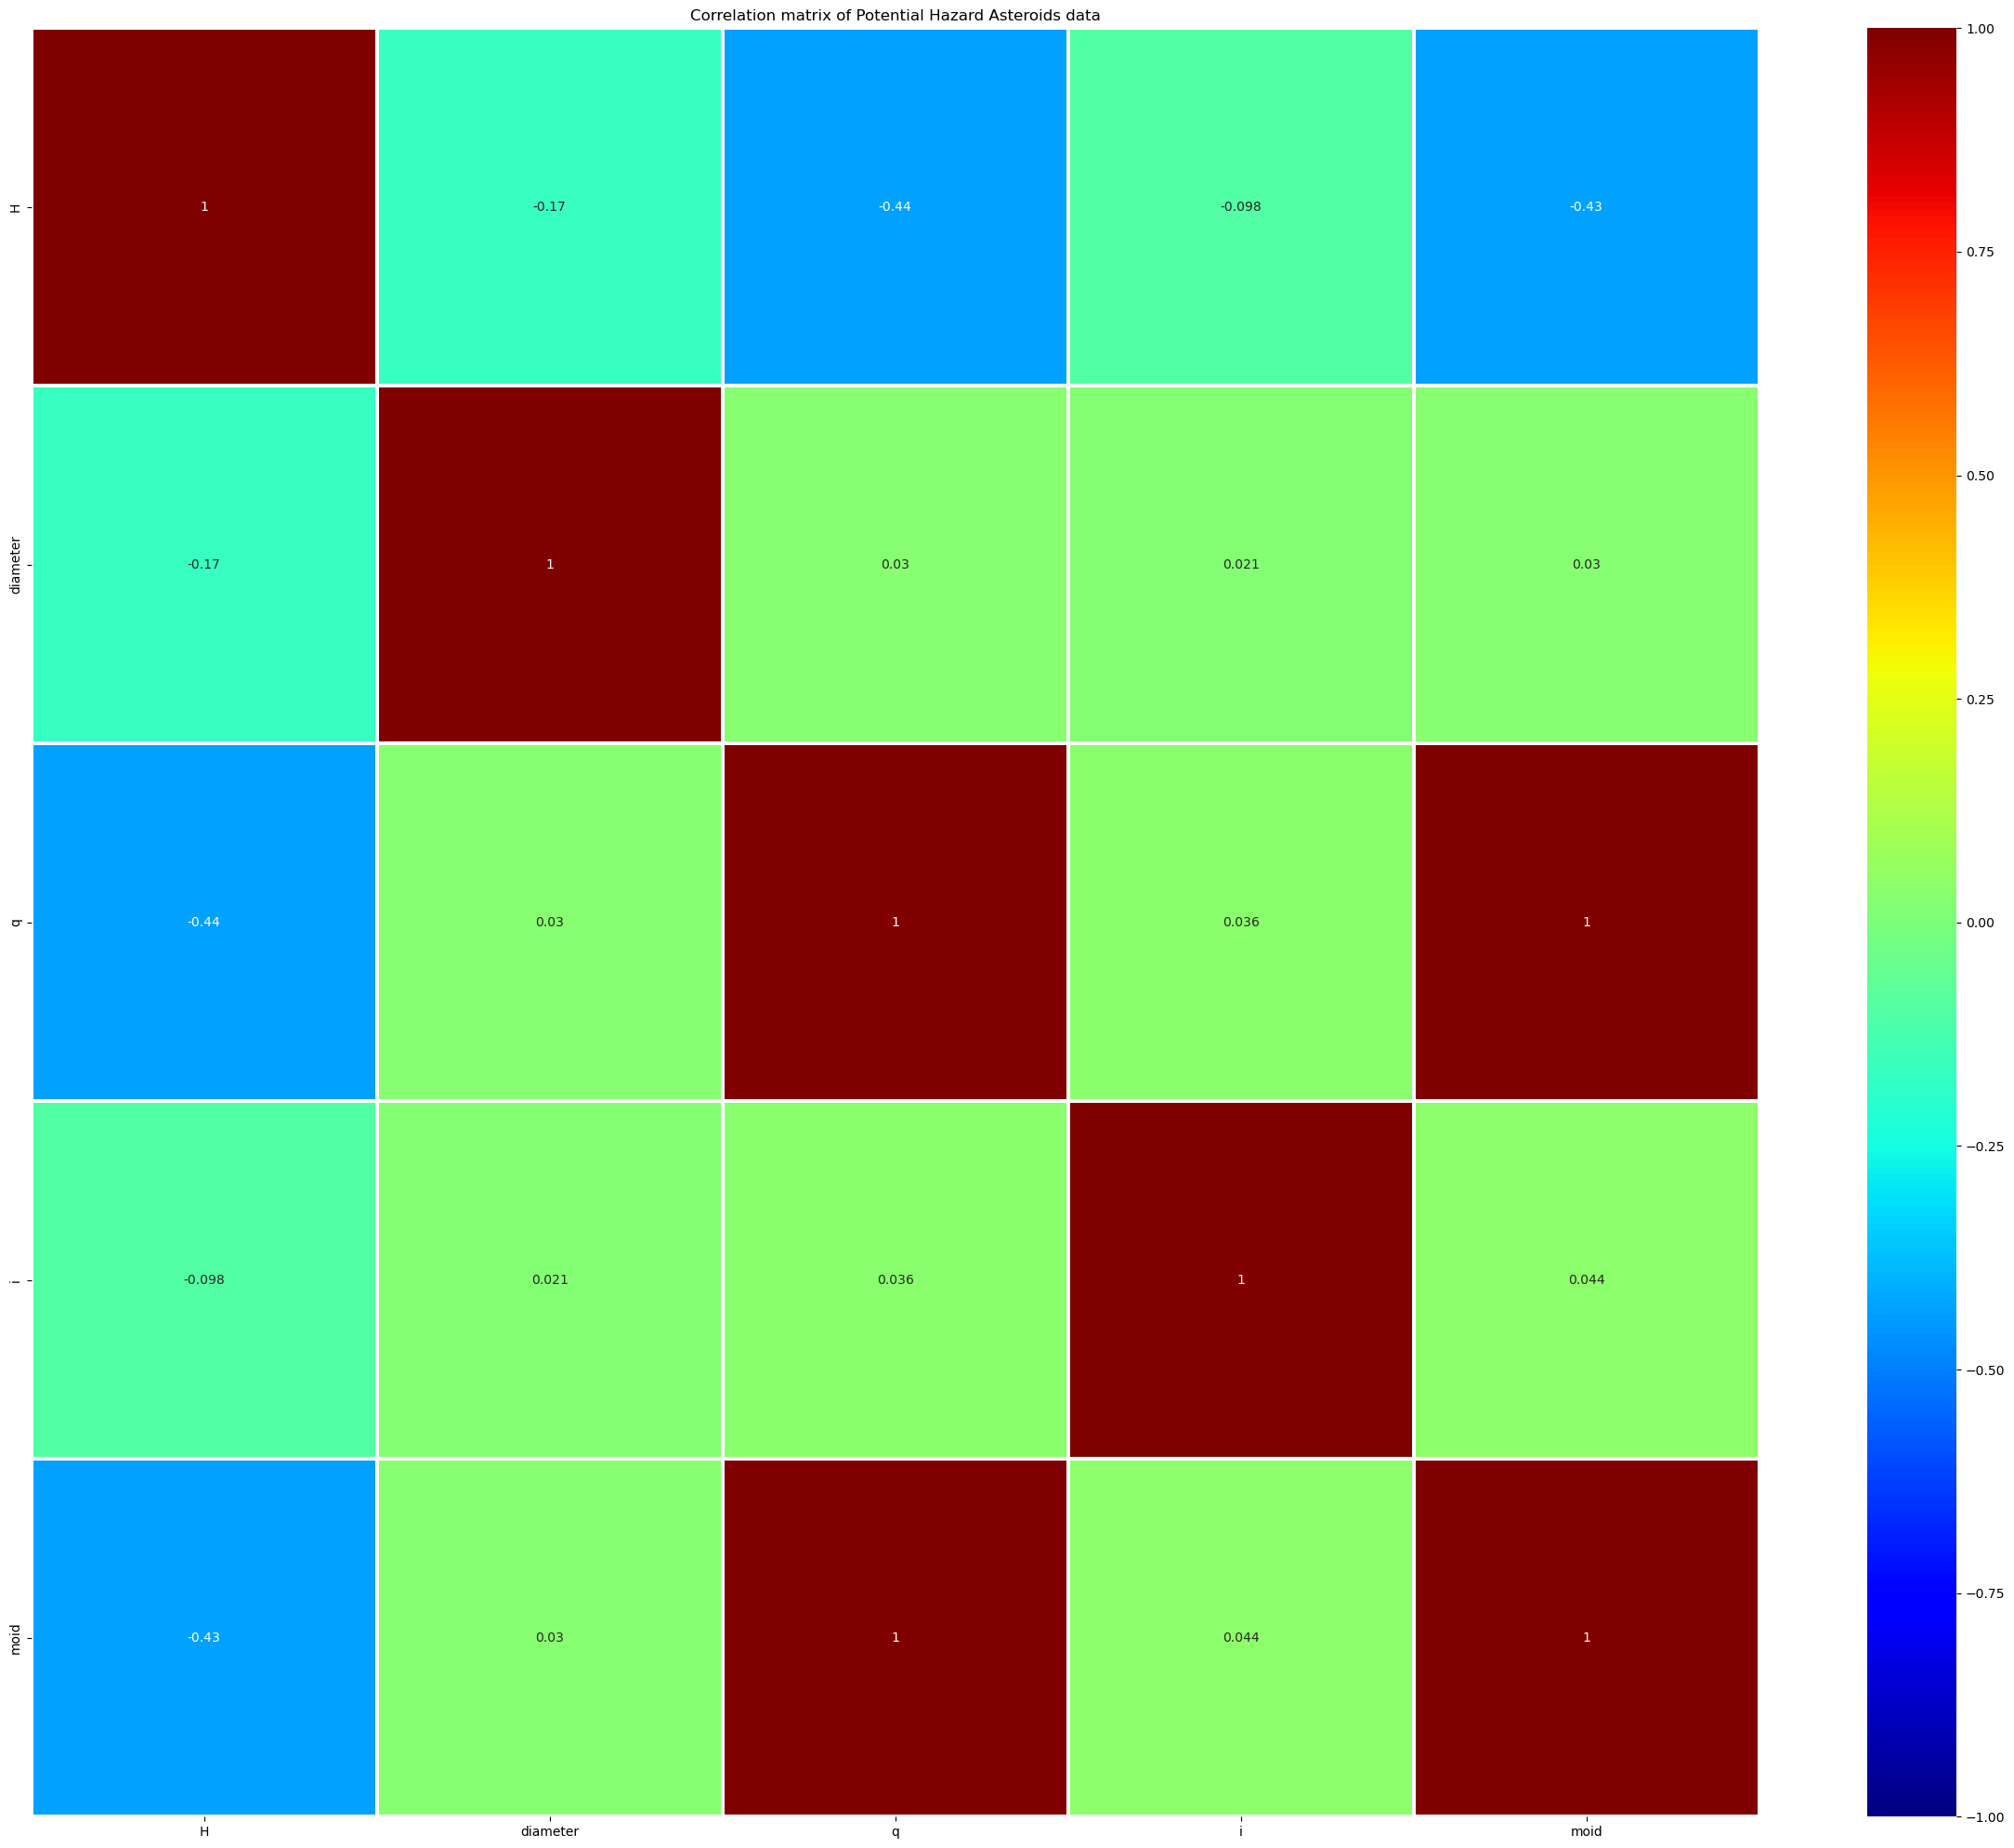

In [47]:
correlation_matrix = data.corr()
plt.figure(figsize=(30, 25))
plt.title("Correlation matrix of Potential Hazard Asteroids data")
sns.heatmap(data=correlation_matrix, cmap='jet', vmin=-1, vmax=1, linewidth=1.5, annot=True)
fig1 = plt.gcf()
plt.show()
fig1.savefig("correlationmatrix1.png")

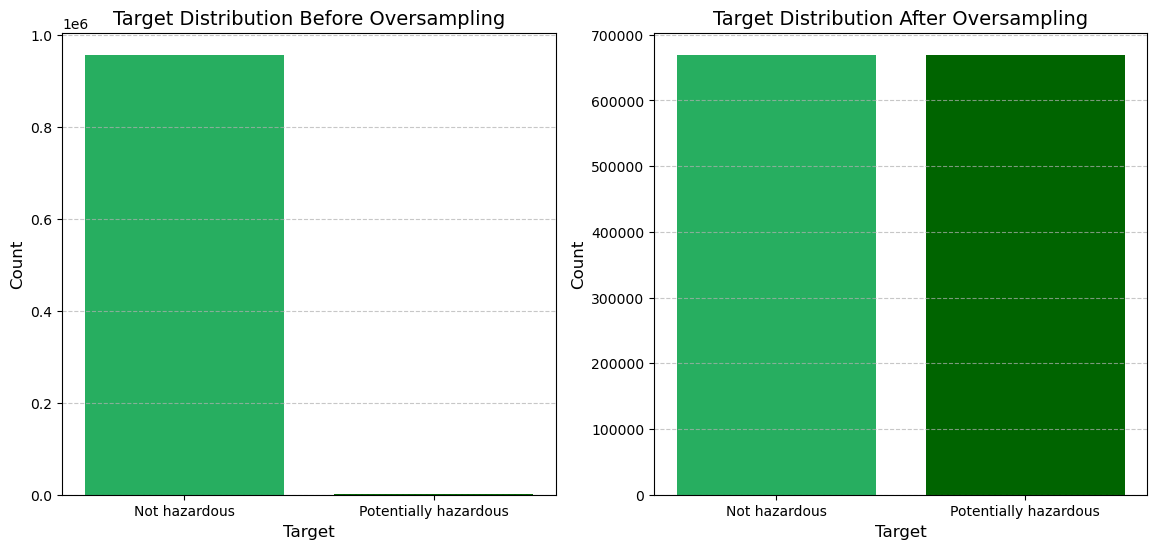

In [52]:
def compare_target_distribution(y_before: pd.Series, y_after: pd.Series, labels: list):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    y_before_counts = y_before.value_counts()
    y_after_counts = y_after.value_counts()

    # Customize bar colors
    bar_colors = [ '#27AE60','#006400']

    axes[0].bar(labels, y_before_counts, color=bar_colors)
    axes[0].set_title('Target Distribution Before Oversampling', fontsize=14)
    axes[0].set_xlabel('Target', fontsize=12)
    axes[0].set_ylabel('Count', fontsize=12)
    axes[0].grid(axis='y', linestyle='--', alpha=0.7)

    axes[1].bar(labels, y_after_counts, color=bar_colors)
    axes[1].set_title('Target Distribution After Oversampling', fontsize=14)
    axes[1].set_xlabel('Target', fontsize=12)
    axes[1].set_ylabel('Count', fontsize=12)
    axes[1].grid(axis='y', linestyle='--', alpha=0.7)

    # Make background transparent
    fig.patch.set_visible(False)
    axes[0].set_facecolor((1.0, 1.0, 1.0, 0.0))
    axes[1].set_facecolor((1.0, 1.0, 1.0, 0.0))

    plt.show()


labels = ['Not hazardous', 'Potentially hazardous']
compare_target_distribution(target, y_train, labels)


## Find the best Machine Learning Model

In [49]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


def select_best_model(X_train, y_train):
    models = [
        ('Logistic Regression', LogisticRegression(random_state=42)),
        ('K-Nearest Neighbors', KNeighborsClassifier()),
        ('Decision Tree', DecisionTreeClassifier(random_state=42)),
        ('Random Forest', RandomForestClassifier(random_state=42)),
        ('Gradient Boosting', GradientBoostingClassifier(random_state=42))
    ]

    results = []
    for name, model in models:
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
        results.append((name, scores.mean()))
        print(f"{name}: {scores.mean():.4f}")

    return max(results, key=lambda x: x[1])[0]


best_model_name = select_best_model(X_train, y_train)
print(f"Best model: {best_model_name}")


Logistic Regression: 0.9995
K-Nearest Neighbors: 0.9990
Decision Tree: 0.9999
Random Forest: 1.0000
Gradient Boosting: 1.0000
Best model: Random Forest


## Training with MlFlow

In [50]:
import mlflow
import mlflow.sklearn

def train_and_tune_model(X_train, y_train, X_val, y_val, n_estimators, max_depth):
    classifier = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42, class_weight='balanced')
    classifier.fit(X_train, y_train)

    # Evaluate the model
    y_pred = classifier.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    auc_roc = roc_auc_score(y_val, y_pred)

    return classifier, accuracy, auc_roc

n_estimators_list = [10, 50, 100, 200]
max_depth_list = [3, 6, 10]

mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("Asteroid_PHA_Prediction")

best_auc_roc = 0
best_n_estimators = 0
best_max_depth = 0

for n_estimators in n_estimators_list:
    for max_depth in max_depth_list:
        print(f"Training with {n_estimators} estimators and max_depth {max_depth}")

        with mlflow.start_run():
            trained_classifier, accuracy, auc_roc = train_and_tune_model(X_train, y_train, X_val, y_val, n_estimators, max_depth)

            # Log the n_estimators and max_depth values
            mlflow.log_param("n_estimators", n_estimators)
            mlflow.log_param("max_depth", max_depth)

            # Log the metrics
            mlflow.log_metric("accuracy", accuracy)
            mlflow.log_metric("auc_roc", auc_roc)

            # Log model
            mlflow.sklearn.log_model(trained_classifier, "model")

            print(f"Accuracy: {accuracy}")
            print(f"AUC-ROC: {auc_roc}")
            print("\n")

            # Save the best combination of parameters based on AUC-ROC
            if auc_roc > best_auc_roc:
                best_auc_roc = auc_roc
                best_n_estimators = n_estimators
                best_max_depth = max_depth


def evaluate_model(classifier, X_val, y_val):
    """Evaluates the trained model on test data."""
    y_pred = classifier.predict(X_test)

    print("Accuracy:", accuracy_score(y_val, y_pred))
    print("Classification Report:\n", classification_report(y_val, y_pred))
    print("AUC-ROC:", roc_auc_score(y_val, y_pred))


# Train the final model with the best n_estimators and max_depth values
trained_classifier, _, _ = train_and_tune_model(X_train, y_train, X_val, y_val, best_n_estimators, best_max_depth)
evaluate_model(trained_classifier, X_test, y_test)


Training with 10 estimators and max_depth 3
Accuracy: 0.99520800733262
AUC-ROC: 0.9952080240330663


Training with 10 estimators and max_depth 6
Accuracy: 0.9998745369192541
AUC-ROC: 0.9998745373565021


Training with 10 estimators and max_depth 10
Accuracy: 0.9999302982884745
AUC-ROC: 0.99993029853139


Training with 50 estimators and max_depth 3
Accuracy: 0.9997839246942709
AUC-ROC: 0.9997839254473091


Training with 50 estimators and max_depth 6
Accuracy: 0.9998710518336777
AUC-ROC: 0.9998710522830716


Training with 50 estimators and max_depth 10
Accuracy: 0.9999302982884745
AUC-ROC: 0.99993029853139


Training with 100 estimators and max_depth 3
Accuracy: 0.9998675667481015
AUC-ROC: 0.9998675672096411


Training with 100 estimators and max_depth 6
Accuracy: 0.9998710518336777
AUC-ROC: 0.9998710522830716


Training with 100 estimators and max_depth 10
Accuracy: 0.9999268132028982
AUC-ROC: 0.9999268134579596


Training with 200 estimators and max_depth 3
Accuracy: 0.9998675667481015

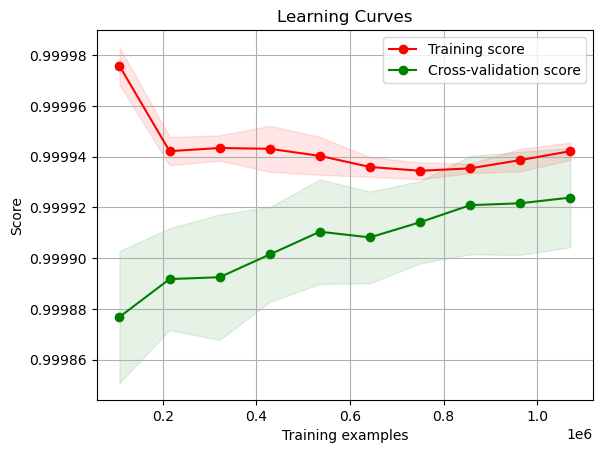

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve


def plot_learning_curve(estimator, X_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X_train, y_train, cv=cv, n_jobs=n_jobs,
                                                            train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.title("Learning Curves")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")

    return plt


best_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

plot_learning_curve(best_model, X_train, y_train)
plt.show()